# Charactor-level RNN.cpu for shakespear_1

    modified from https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

import time
import math


In [25]:
# parameter
keywords_dict ={}
keywords_dict['hidden_size'] = 100
keywords_dict['seq_length'] = 25
keywords_dict['learning_rate'] = 0.001
data = open('data/shakespeare_input.txt', 'r').read() # should be simple plain text file
data = data[:1000000]
chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
print('data has %d characters, %d unique.' % (data_size, vocab_size))
char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }
keywords_dict['all_letters'] = ''.join(sorted(chars))
keywords_dict['n_letters'] = len(chars)
keywords_dict['data_size'] = data_size

data has 1000000 characters, 65 unique.


In [26]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.Wxh = nn.Linear(input_size, hidden_size)
        self.Whh = nn.Linear(hidden_size, hidden_size)
        self.Why = nn.Linear(hidden_size, output_size)
        self.act = nn.Tanh()
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, _input, hidden):
        # np.tanh(np.dot(Wxh, xs[t]) + np.dot(Whh, hs[t-1]) + bh)
        hidden = self.Wxh(_input).add(self.Whh(hidden))
        hidden = self.act(hidden)
        
        output = self.Why(hidden)
        
        # output
#         output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [27]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [28]:
# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line, keywords_dict):
    all_letters = keywords_dict['all_letters']
    n_letters = keywords_dict['n_letters']
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
#         print(letter)
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# LongTensor of second letter to end (EOS) for target
def targetTensor(line, keywords_dict):
    all_letters = keywords_dict['all_letters']
    n_letters = keywords_dict['n_letters']
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

def createTrainingExample(line, keywords_dict):
#     category, line = randomTrainingPair()
#     line = randomChoice(keywords_dict['name_vector'])
#     category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line[:-1], keywords_dict)
#     print(input_line_tensor)
    target_line_tensor = targetTensor(line[1:], keywords_dict)
#     print(target_line_tensor)

#     return category_tensor, input_line_tensor, target_line_tensor
    return input_line_tensor, target_line_tensor

In [34]:
def running(rnn, optimizer, keywords_dict):
    seq_length = keywords_dict['seq_length']

    print_every = 5000
    plot_every = 500
    start = time.time()
    
    all_losses = []
    total_loss = 0 # Reset every plot_every iters
    loss_fun = nn.NLLLoss()

    _iter, p = 0, 0
    epoch = 0
    while epoch < 10:
        if p + seq_length +1 >= len(data):
            epoch +=1
            p = 0
        input_line_tensor, target_line_tensor = createTrainingExample(data[p:p+seq_length+1], keywords_dict)
#         print(input_line_tensor)
        target_line_tensor.unsqueeze_(-1)
        hidden = rnn.initHidden()
        rnn.zero_grad()

        loss = 0

        for i in range(input_line_tensor.size(0)):
            output, hidden = rnn(input_line_tensor[i], hidden)

            l = loss_fun(output, target_line_tensor[i])
            loss += l
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

#         for para in rnn.parameters():
#             para.data.add_(-learning_rate, para.grad.data)

        p += seq_length # move data pointer
        _iter += 1 # iteration counter

        total_loss += loss

        if _iter % print_every == 0:
            print('%s (%d %d%%) %.4f' % (timeSince(start), _iter, _iter / (keywords_dict['data_size']/keywords_dict['seq_length']) * 100, loss))

        if _iter % plot_every == 0:
            all_losses.append(total_loss / plot_every)
            total_loss = 0
    return rnn, optimizer, all_losses
rnn = RNN(keywords_dict['n_letters'], keywords_dict['hidden_size'], keywords_dict['n_letters'])
optimizer = torch.optim.Adam(rnn.parameters(), lr=keywords_dict['learning_rate'])
rnn, optimizer, all_losses = running(rnn, optimizer, keywords_dict)

0m 34s (5000 12%) 70.1070
1m 9s (10000 25%) 73.4348
1m 44s (15000 37%) 56.4243
2m 19s (20000 50%) 59.2242
3m 0s (25000 62%) 62.6631
3m 37s (30000 75%) 47.7216
4m 11s (35000 87%) 65.3272
4m 46s (40000 100%) 70.9743
5m 20s (45000 112%) 61.2522
5m 55s (50000 125%) 68.6125
6m 29s (55000 137%) 70.4228
7m 4s (60000 150%) 59.5296
7m 39s (65000 162%) 76.0783
8m 14s (70000 175%) 68.0206
8m 48s (75000 187%) 45.2047
9m 23s (80000 200%) 58.5100
9m 58s (85000 212%) 67.6228
10m 33s (90000 225%) 60.5775
11m 8s (95000 237%) 83.5743
11m 43s (100000 250%) 55.2759
12m 18s (105000 262%) 57.5789
12m 53s (110000 275%) 65.5471
13m 27s (115000 287%) 43.0770
14m 2s (120000 300%) 72.7007
14m 37s (125000 312%) 64.4571
15m 11s (130000 325%) 77.0386
15m 46s (135000 337%) 75.1341
16m 21s (140000 350%) 48.0656
16m 56s (145000 362%) 67.5007
17m 30s (150000 375%) 60.7033
18m 5s (155000 387%) 52.4288
18m 40s (160000 400%) 62.8611
19m 15s (165000 412%) 69.8920
19m 49s (170000 425%) 66.7631
20m 24s (175000 437%) 70.7737


In [18]:
# rnn, all_losses = running(rnn, keywords_dict)

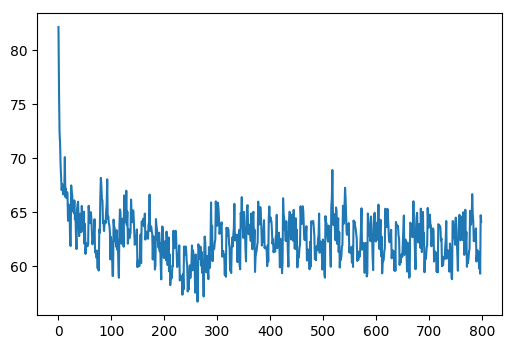

In [35]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
plt.figure()
plt.plot(all_losses)

In [44]:
import random
def generate_letter(dist):
        x = random.random()
        for c,v in enumerate(dist):
            x = x - v
            if x <= 0: return c
import numpy as np
# Sample from a category and starting letter
def sample(rnn, keywords_dict, start_letter='E', max_length=25):
    with torch.no_grad():  # no need to track history in sampling
#         category_tensor = categoryTensor(category)
        _input = inputTensor(start_letter, keywords_dict)
        hidden = rnn.initHidden()

        outputs = start_letter

        for i in range(keywords_dict['seq_length']):
            output, hidden = rnn(_input[0], hidden)
            topv, topi = output.topk(1)
#             dist = np.exp(np.array(output)[0])
#             print(dist)
            topi = topi[0][0]
#             letter = keywords_dict['all_letters'][generate_letter(dist)]
            letter = keywords_dict['all_letters'][topi]

            outputs += letter
            _input = inputTensor(letter, keywords_dict)

        return outputs
s = sample(rnn, keywords_dict)
print(s)

ETI:I:I:I:s ee o o er o o 


In [19]:
random.random()

0.1873001867320201

In [13]:
from torch import FloatTensor
from torch.autograd import Variable


# Define the leaf nodes
a = Variable(FloatTensor([4]))

weights = [Variable(FloatTensor([i]), requires_grad=True) for i in (2, 5, 9, 7)]

# unpack the weights for nicer assignment
w1, w2, w3, w4 = weights

b = w1 * a
c = w2 * a
d = w3 * b + w4 * c
L = (10 - d)

L.backward()

for index, weight in enumerate(weights, start=1):
    gradient, *_ = weight.grad.data
    print("Gradient of w", index , "w.r.t to L: ", gradient)

Gradient of w 1 w.r.t to L:  tensor(-36.)
Gradient of w 2 w.r.t to L:  tensor(-28.)
Gradient of w 3 w.r.t to L:  tensor(-8.)
Gradient of w 4 w.r.t to L:  tensor(-20.)


AttributeError: 'Tensor' object has no attribute 'items'

In [8]:
x = torch.tensor([1, 2, 3, 4])

In [9]:
x.unsqueeze_(-1)

tensor([[1],
        [2],
        [3],
        [4]])

In [3]:
4*(3* (516 * 516 + 516) +2*516*68+68+518+68)

3484584